# Прогнозирование временных рядов при помощи AutoML (на примере фреймворка FEDOT)
#### FEDOT version = 0.3.1

In [ ]:
pip install fedot==0.3.1

[Репозиторий на GitHub](https://github.com/nccr-itmo/FEDOT)

Данный демонстрационный материал был подготовлен [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

In [90]:
# Chain and nodes
from fedot.core.chains.chain import Chain
from fedot.core.chains.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

In [91]:
# Additional imports are required
import os 

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

Читаем датафрейм с данными

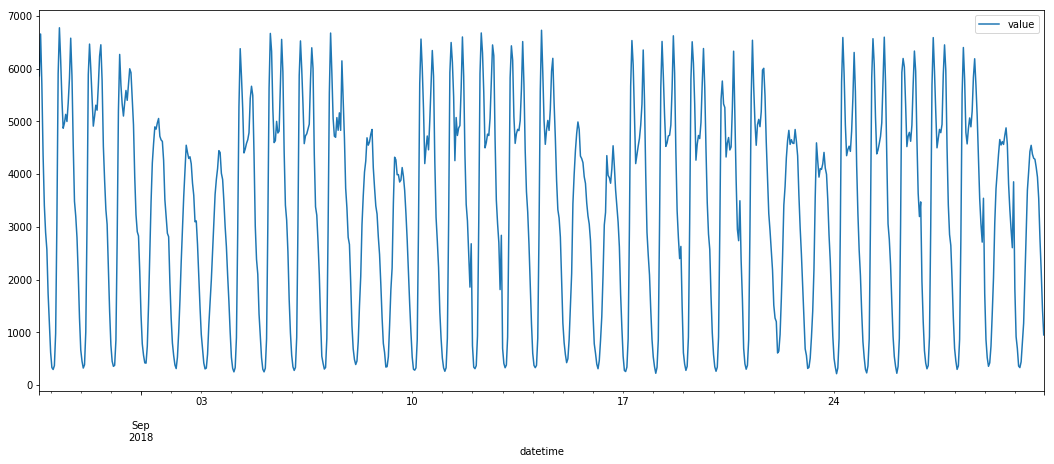

Length of the time series - 801


In [92]:
# Import data
df = pd.read_csv('ts_traffic.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# Plot data
df.plot('datetime', 'value')
plt.show()

print(f'Length of the time series - {len(df)}')

In [93]:
def get_tree_chain():
    """ Return chain: lagged -> treg """
    node_lagged = PrimaryNode('lagged')
    node_final = SecondaryNode('treg', nodes_from=[node_lagged])
    chain = Chain(node_final)
    
    return chain


def get_two_branches_chain(lagged_param_1=10, lagged_param_2=10,
                           model_1='ridge', model_2='ridge', model_3='ridge'):
    """
    Chain looking like this
    lagged -> model_1 \
                       \
                        model_3 -> final forecast
                       /
    lagged -> model_2 /
    """
    # First level
    node_lagged_1 = PrimaryNode('lagged')
    node_lagged_1.custom_params = {'window_size': lagged_param_1}
    node_lagged_2 = PrimaryNode('lagged')
    node_lagged_2.custom_params = {'window_size': lagged_param_2}

    # Second level
    node_second_1 = SecondaryNode(model_1, nodes_from=[node_lagged_1])
    node_second_2 = SecondaryNode(model_2, nodes_from=[node_lagged_2])

    # Third level - root node
    node_final = SecondaryNode(model_3, nodes_from=[node_second_1, node_second_2])
    chain = Chain(node_final)
    
    return chain


def get_hybrid_chain():
    """
    Chain looking like this
    lagged ->  dtreg  \
                       \
                        treg -> final forecast
                       /
            ar        /
    """
    
    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': 200}
    node_dtreg = SecondaryNode('dtreg', nodes_from=[node_lagged])
    
    # Simple parameters for ARIMA
    node_arima = PrimaryNode('arima')
    node_arima.custom_params = {'p': 0, 'd': 0, 'q': 1}
    node_final = SecondaryNode('treg', nodes_from=[node_dtreg, node_arima])
    chain = Chain(node_final)
    
    return chain


def display_results(actual_time_series, predicted_values, len_train_data, y_name = 'Traffic volume'):
    """
    Function for drawing plot with predictions and check metrics
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()
    
    mae_value = mean_absolute_error(actual_time_series[len_train_data:], predicted_values)
    print(f'MAE value: {mae_value}')

In [94]:
forecast_length = 144

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))

# Load data from csv file and wrap it into InputData structure
input_data = InputData.from_csv_time_series(task, 'ts_traffic.csv', target_column='value')

# Divide into train and test 
train_data, test_data = train_test_data_setup(input_data)

## Прогнозирование при помощи простой цепочки с нелинейной моделью

<img src="images/pipeline_1.png" width="500"/>

*Из-за того, что output ячейки ниже содержит в себе большое количество лог-сообщений, output не приводится

In [ ]:
non_lin_chain = get_tree_chain()

# Tune this chain 
non_lin_chain = non_lin_chain.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                                  loss_params=None,
                                                  input_data=train_data,
                                                  iterations=30)
# Make prediction
tuned_output = non_lin_chain.predict(test_data)
tuned_forecast = np.ravel(np.array(tuned_output.predict))

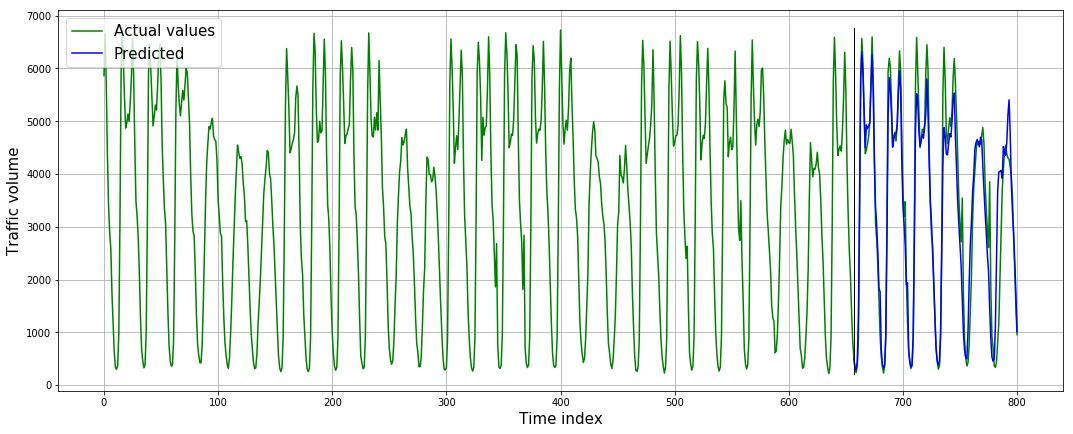

MAE value: 432.1153472222222


In [16]:
display_results(input_data.target, tuned_forecast, len(train_data.features))

## Прогнозирование при помощи сложной цепочки с несколькими "ветвями"

<img src="images/pipeline_2.png" width="500"/>

*Из-за того, что output ячейки ниже содержит в себе большое количество лог-сообщений, output не приводится

In [ ]:
two_branches_chain = get_two_branches_chain()

# Tune this chain 
two_branches_chain = two_branches_chain.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                                            loss_params=None,
                                                            input_data=train_data,
                                                            iterations=30)
# Make prediction
tuned_output = two_branches_chain.predict(test_data)
tuned_forecast = np.ravel(np.array(tuned_output.predict))

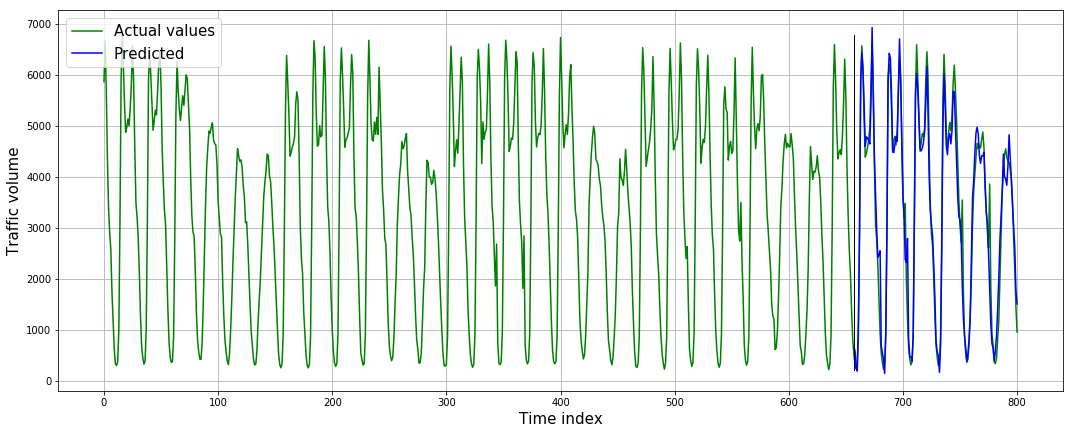

MAE value: 299.6834511638749


In [99]:
display_results(input_data.target, tuned_forecast, len(train_data.features))

## Прогнозирование при помощи гибридной композитной модели

<img src="images/pipeline_3.png" width="500"/>

In [100]:
hybrid_chain = get_hybrid_chain()

# Fit this chain 
hybrid_chain.fit(train_data)

# Make prediction
output = hybrid_chain.predict(test_data)
forecast = np.ravel(np.array(output.predict))

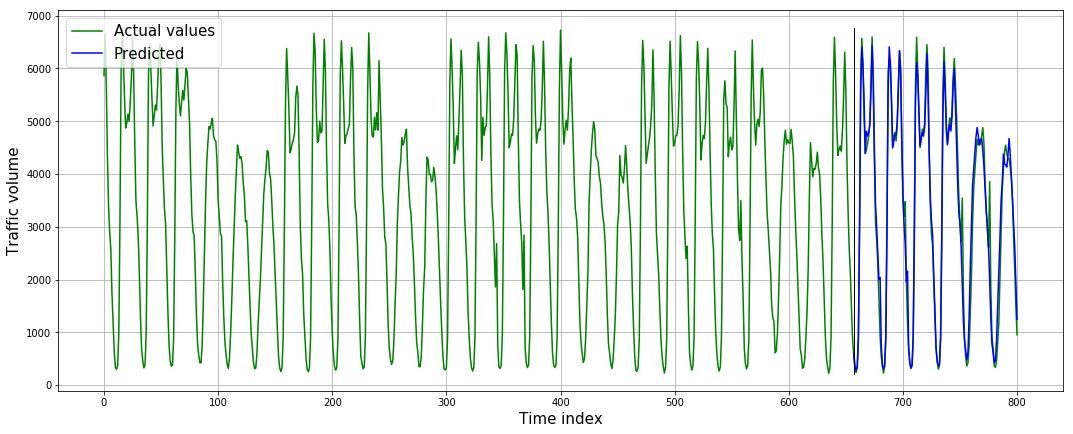

MAE value: 231.40305555555557


In [101]:
display_results(input_data.target, forecast, len(train_data.features))